# Project: Building a Traffic Sign Recognition Classifier

## Self-Driving Car Engineer Nanodegree

###### Keywords: Deep Learning, Inception Module, Convolutional Neural Networks 

---
## Load Libraries and the Data

In [1]:
import pickle
import time
import numpy as np
import tensorflow as tf
import seaborn as sns

from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle


In [2]:
training_file = 'train_aug.p' #augmented training data
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

In [3]:
#checking if data is loaded properly
assert len(x_train) == len(y_train)
assert len(x_valid) == len(y_valid)
assert len(x_test) == len(y_test)

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [4]:
# Number of training examples
n_train = len(y_train)

# Number of validation examples
n_validation = len(y_valid)

# Number of testing examples.
n_test = len(y_test)

# Shape of an traffic sign image.
image_shape = np.shape(x_train[0])

# Unique classes 
unq_classes = np.unique(y_train)

# Unique classes/labels there are in the dataset.
n_classes = len(unq_classes)

# Bincount labels in training set
bin_count = np.bincount(y_train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 196045
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


###### Exploratory visualization of the dataset

Sample traffic sign images, plot of count of each sign. 

**Futrue Work:** It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

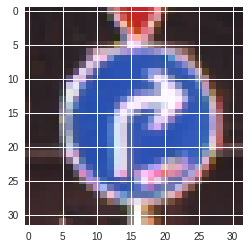

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Sample visualization of traffic sign 
plt.imshow(x_train[190000])
plt.show()

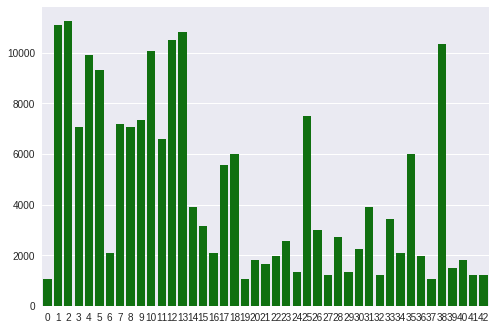

In [6]:
# plot of no of training data for each class 
sns.set(style="darkgrid")
sns.barplot(x=unq_classes, y=bin_count, color='green')
sns.plt.show()

----

## Model Architecture

###### Pre-processing the Data Set (normalization etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data that will be used in this project. 

In [7]:
x_train = x_train/255
x_t_t = np.average(x_train, axis=0)

In [8]:
x_valid = x_valid/255
x_valid = x_valid - x_t_t

x_test = x_test/255
x_test = x_test - x_t_t


###### Model Architecture

Architecture consists of two convolution layers, an Inception module (more on this later), max pool layers and fully connected neural network.

<figure>
 <img src="extras/Architecture.png" width="580"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Model Architecture</p> 
 </figcaption>
</figure>
 <p></p> 

In [9]:
#model parameters
learning_rate = 0.001
epochs = 65
batch_size = 9000

In [10]:
#weights and bias
#first convolution weight and bias
cnw_1 = tf.Variable(tf.truncated_normal([5,5,3,8], mean=0, stddev=0.1)) #stride 1
cnb_1 = tf.Variable(tf.zeros([8]))

#second convolution weight and bias
cnw_2 = tf.Variable(tf.truncated_normal([3,3,8,16], mean=0, stddev=0.1)) #stride 1
cnb_2 = tf.Variable(tf.zeros([16]))

#weights and bias for first inception module
weights_1 = {'icnw1': tf.Variable(tf.truncated_normal([1,1,16,32])),
          'icnw2': tf.Variable(tf.truncated_normal([1,1,16,20])),
          'icnw23': tf.Variable(tf.truncated_normal([3,3,20,24])),
          'icnw3': tf.Variable(tf.truncated_normal([1,1,16,20])),
          'icnw35': tf.Variable(tf.truncated_normal([5,5,20,24])),
          'icnwm1': tf.Variable(tf.truncated_normal([1,1,16,32]))}

bias_1 = {'icnb1': tf.Variable(tf.zeros([32])),
          'icnb2': tf.Variable(tf.zeros([20])),
          'icnb23': tf.Variable(tf.zeros([24])),
          'icnb3': tf.Variable(tf.zeros([20])),
          'icnb35': tf.Variable(tf.zeros([24])),
          'icnbm1': tf.Variable(tf.zeros([32]))}

#fully connected weights and bias
# 1008 to 86
nnwts_1 = tf.Variable(tf.truncated_normal([1008, 86], mean=0, stddev=0.1))
nnb_1 = tf.Variable(tf.zeros([86]))

# 86 to 43
nnwts_2 = tf.Variable(tf.truncated_normal([86, 43], mean=0, stddev=0.1))
nnb_2 = tf.Variable(tf.zeros([43]))

<figure>
 <img src="extras/Inception.png" width="580"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Inception Module Architecture</p> 
 </figcaption>
</figure>
 <p></p> 


In [11]:
#learning rate function
def lr_fn(epoch):
  if(epoch <= 55):
    return 0.001
  else:
    return 0.0005


#NN layerincluding relu activation
def NN_lay(x, wts, bias):
    x = tf.add(tf.matmul(x, wts), bias)
    return tf.nn.relu(x)

#does a convolution and a relu activation
def conv_(x, wts, bias, strides=1, padding='VALID'):
    x = tf.nn.conv2d(x, wts, [1,strides,strides,1], padding)
    x = tf.nn.bias_add(x, bias)
    return tf.nn.relu(x)  

#maxpooling layer
def maxpool_(x, k=2, stride=1,padding='SAME'):
    return tf.nn.max_pool(x, [1,k,k,1], [1,stride,stride,1], 'SAME')    

#concatenates the four parallel layers of inception module 
#each layers passed should have same dimens except for last axis(-1)
def concat_lay(lay_1, lay_2, lay_3, lay_4, axis=-1):
    lay_1 = tf.unstack(lay_1, axis=axis) #this creates a list unpacked along last axis(-1)
    
    lay_1.extend(tf.unstack(lay_2, axis=axis)) #extending the previous list
    lay_1.extend(tf.unstack(lay_3, axis=axis))
    lay_1.extend(tf.unstack(lay_4, axis=axis))
    
    return tf.stack(lay_1, axis=axis) #re stacking the layers along the last axis(-1)

#inception modules takes x, weights, bias etc.
#pad_wt is a param for padding to be done for max_pool layer
def inception(x, iweights, ibias, pad_wt,strides=1, padding = 'SAME', k=2):
    #1-1 filter conv layer
    lay_1 = conv_(x, iweights['icnw1'],ibias['icnb1'], strides=strides, padding = padding)
    
    #1-1 filter conv layer and then 3-3 conv layer
    lay_2 = conv_(x, iweights['icnw2'],ibias['icnb2'], strides=strides, padding = padding)
    lay_2 = conv_(lay_2, iweights['icnw23'],ibias['icnb23'], strides=strides, padding = padding)
    
    #1-1 filter conv layer and then 5-5 conv layer
    lay_3 = conv_(x, iweights['icnw3'],ibias['icnb3'], strides=strides, padding = padding)
    lay_3 = conv_(lay_3, iweights['icnw35'],ibias['icnb35'], strides=strides, padding = padding)
    
    #max_pool layer and then a 1-1 conv layer
    lay_4 = maxpool_(x, k=k, padding=padding)
    lay_4 = conv_(lay_4, iweights['icnwm1'],ibias['icnbm1'], strides=strides, padding = padding)
    
    #concatenating the layers
    return concat_lay(lay_1, lay_2, lay_3, lay_4)

In [12]:
x = tf.placeholder(tf.float32, [None,32,32,3])
y_ = tf.placeholder(tf.int32, [None])
y = tf.one_hot(y_, 43)
l = tf.placeholder(tf.float32) #learning rate placeholder

#first layer, a convolution layer
#inp: 32x32x3 to out: 28x28x8
logits = conv_(x, cnw_1, cnb_1, strides=1, padding='VALID')
#inp: 28x28x8 to out: 14x14x8
logits = tf.nn.max_pool(logits, [1,2,2,1], [1,2,2,1], 'VALID')

#second layer, a convolution layer
#inp: 14x14x8 to out: 12x12x16
logits = conv_(logits, cnw_2, cnb_2, strides=1, padding='VALID')
#inp: 12x12x16 to out: 6x6x16
logits = tf.nn.max_pool(logits, [1,2,2,1], [1,2,2,1], 'VALID')

#third layer, a inception module
#inp: 6x6x16 to out: 6x6x112
logits = inception(logits, weights_1, bias_1, 1, k=3)
logits = tf.nn.max_pool(logits, [1,2,2,1], [1,2,2,1], 'VALID')

#flatten the tensor: 3*3*112 = 1008
logits = flatten(logits)

#fully connected layer 1: 1008 to 86
logits = NN_lay(logits, nnwts_1, nnb_1)

#fully connected layer 2: 86 to 43
logits = tf.add(tf.matmul(logits, nnwts_2), nnb_2)

#cross entropy loss is objective function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# Optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate=l).minimize(cost)

In [13]:
# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#top 5 accuracy
top_5 = tf.nn.in_top_k(tf.nn.softmax(logits), tf.argmax(y, 1), 5)
top_5_acc = tf.reduce_mean(tf.cast(top_5, tf.int32))

###### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
#saving the model
save_file = 'New_wts/model'
saver = tf.train.Saver()

In [15]:
# Initializing the variables
init = tf. global_variables_initializer()

In [16]:
#Add data to lists
loss_train = []
loss_valid_m = [] #has more points
loss_valid = []
acc_valid = []


In [ ]:
with tf.Session() as sess:
    sess.run(init)
    num_ex = len(x_train)
    
    no_of_batches = int(len(x_train)/batch_size)
    x_t, y_t = shuffle(x_train, y_train)
    for epoch in range(epochs):
        strt_tym = time.time()
        for offset in range(no_of_batches):
            idx = np.random.randint(0, high=len(x_t), size=batch_size)
            batch_x, batch_y = x_t[idx], y_t[idx]
            
            sess.run(optimizer, feed_dict={x:batch_x, y_:batch_y, l:lr_fn(epoch)})
            loss = sess.run(cost, feed_dict={x:batch_x, y_:batch_y})
            
            #saving training loss in the list
            loss_train.append(loss)
            
            #saving validation loss in the list
            loss_valid_m.append(sess.run(cost, feed_dict={x: x_valid, y_: y_valid}))
            
        end_tym = time.time()
        
        loss_valid.append(sess.run(cost, feed_dict={x: x_valid, y_: y_valid}))  
        val_acc = sess.run(accuracy, feed_dict={x: x_valid, y_: y_valid})
        acc_valid.append(val_acc)
        print('/******************************************************************/')
        print('no of epoch: ',epoch)
        print('loss: ',loss)
        print('accuracy: ', val_acc)
        print('time in sec for an epoch: ', end_tym - strt_tym)
    saver.save(sess, save_file)
    t_acc = sess.run(accuracy, feed_dict={x: x_test, y_: y_test})
    print('test accuracy: ', t_acc)
    print('top 5 accuracy: ', sess.run(top_5_acc, feed_dict={x: x_test, y_:y_test}))


In [ ]:
with open("diag.pickle", "wb") as f:
    pickle.dump((loss_train, loss_valid_m, loss_valid, acc_valid), f)


Training was done on google cloud computing engine with with 2 vCPUs with 13GB memory and a nVidia Tesla K80 GPU. Training time for each epoch is approximately 22 seconds. I reloaded the saved model for following cells

In [17]:
with tf.Session() as sess:
    sess.run(init)
    new_saver = tf.train.import_meta_graph('New_wts/model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('New_wts/./'))  
    print(sess.run(accuracy, feed_dict={x: x_valid, y_: y_valid}), " is the validation accuracy")
    print(sess.run(accuracy, feed_dict={x: x_test, y_: y_test}), " is the test accuracy")
    a = sess.run(top_5, feed_dict={x: x_test, y_: y_test})
    '''a is a boolean array indicating whether true label is in top 5 predictions or not'''

0.995692  is the validation accuracy
0.877751  is the test accuracy


In [18]:
#printing top five accuracy
count = 0
for b in a:
    if b:
        count = count + 1
print(count/len(a)) #top five accuracy

0.9805225653206651


---

## Testing Model on New Images

### Load the Images

In [17]:
import matplotlib.image as mpimg

In [18]:
x_new = []
names = ['50_limit_2.jpg','end_32.jpg','keeprt_38.jpg','priority_12.jpg','road_25.jpg']
for name in names:
    temp = 'New_imgs/'+name
    image = mpimg.imread(temp)
    x_new.append(image)
    
x_real = np.array(x_new)
y_real = np.array([2,32,38,12,25])

In [19]:
print(np.shape(x_real))

(5, 32, 32, 3)


In [20]:
x_real = x_real/255
x_real = x_real - x_t_t

### Predict the Sign Type for Each Image and Analyzing Performance

In [21]:
#reloading the graph and testing for new images
with tf.Session() as sess:
    sess.run(init)
    new_saver = tf.train.import_meta_graph('New_wts/model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('New_wts/./'))  
    print(sess.run(accuracy, feed_dict={x: x_real, y_: y_real}), " is the accuracy on real images")
    a_real = sess.run(top_5, feed_dict={x: x_real, y_: y_real})
    '''a_real is a boolean array indicating whether true label is in top 5 predictions or not'''

0.8  is the accuracy on real images


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [24]:
#printing top 5 accuracy
count = 0
for b in a_real:
    if b:
        count = count + 1
print(count/len(a_real), " is the top 5 accuracy on real images")

1.0  is the top 5 accuracy on real images


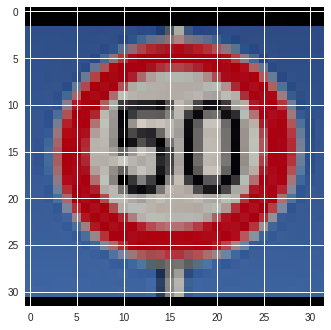

In [27]:
# Sample visualization of real traffic sign 
plt.imshow(x_new[0])
plt.show()

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---
## Diagnostics

In [2]:
import pandas as pd

In [3]:
with open("diag.pickle", "rb") as g:
    zz = pickle.load(g)

In [4]:
loss_train, loss_valid_m, loss_valid, acc_valid = zz

In [5]:
a = {"train_loss": loss_train, "valid_loss": loss_valid_m}
b = {"loss_valid_short": loss_valid}

In [6]:
df = pd.DataFrame.from_dict(a)
df1 = pd.DataFrame.from_dict(b)

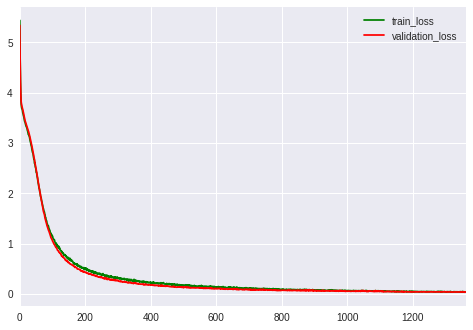

In [7]:
%matplotlib inline
sns.set(style="darkgrid")
sns.tsplot(df.train_loss, color="green", condition='train_loss')
sns.tsplot(df.valid_loss, color="red", condition='validation_loss')
sns.plt.show()

###### Results Analysis
1 epoch = 21 iterations

Zoomed in version of the above graph looks like below. Both training loss and validation loss are smooth which implies that learning rate is good. Training loss didn't increase after steadily decreasing so it can be inferred that there is no over-fitting.  

<figure>
 <img src="extras/zoom_graph.png" width="580"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Loss (y-axis) vs each iteration (x-axis)</p> 
 </figcaption>
</figure>
 <p></p> 


---

## Future work: Visualize the Neural Network's State with Test Images

In [ ]:
### Visualize network's feature maps.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")